# Investigate if numeric encoding can lead to a smoother response surface.

## Main Questions

* Do we get a more smooth response surface, if we use
    * numeric input encoding
    * use narrow network

In [21]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from aimanager.utils.utils import make_dir
from aimanager.utils.merge import merge_files_by_name

sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})

folder = f'../../data/training/baselines/train'
merged_folder = f'../../data/training/baselines/merged'

plot_folder = f'plots/baseline'

make_dir(plot_folder)
make_dir(merged_folder)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
file_names = ['metrics.parquet', 'confusion_matrix.parquet', 'synthetic_predicitions.parquet']

def get_df(file_name, merged_folder, folder):
    m_file = os.path.join(merged_folder, file_name)
    if not os.path.isfile(m_file):
        df = merge_files_by_name(folder, file_name)
        df.to_parquet(m_file)
        return df
    else:
        return pd.read_parquet(m_file)

metrics_df, confusion_matrix_df, synthethetic_df = (
    get_df(file_name, merged_folder, folder)
    for file_name in file_names
)

In [23]:
metrics_df['baseline'].value_counts(dropna=False)

onehot_mlp_graph      18000
onehot_mlp_graph_2    18000
onehot_mlp            10000
Name: baseline, dtype: int64

In [24]:
synthethetic_df.head()

,baseline,set,cv_split,epoch,prev_contribution,prev_punishment,contribution,proba,predicted,idx,round_number,prev_punishments,prev_contributions,pred_contribution
0,onehot_mlp,train,0,999,0.0,0.0,0,0.098716,False,NaN,NaN,NaN,NaN,NaN
1,onehot_mlp,train,0,999,0.0,0.0,1,0.039025,False,NaN,NaN,NaN,NaN,NaN
2,onehot_mlp,train,0,999,0.0,0.0,2,0.022405,False,NaN,NaN,NaN,NaN,NaN
3,onehot_mlp,train,0,999,0.0,0.0,3,0.022313,False,NaN,NaN,NaN,NaN,NaN
4,onehot_mlp,train,0,999,0.0,0.0,4,0.020893,False,NaN,NaN,NaN,NaN,NaN


In [25]:
labels = list(set(metrics_df.columns) - set(['name', 'value', 'cv_split', 'epoch', 'set']))
metrics_df['label'] = ''
bw = ''
for l in labels:
    metrics_df['label'] += (bw + l + ':') + metrics_df[l].astype(str)
    bw = ' '

labels2 = list(set(labels).intersection(confusion_matrix_df.columns))
confusion_matrix_df['label'] = ''
bw = ''
for l in labels2:
    confusion_matrix_df['label'] += (bw + l + ':') + confusion_matrix_df[l].astype(str)
    bw = ' '

labels2 = list(set(labels).intersection(synthethetic_df.columns))
synthethetic_df['label'] = ''
bw = ''
for l in labels2:
    synthethetic_df['label'] += (bw + l + ':') + synthethetic_df[l].astype(str)
    bw = ' '


to_string = ['layers', 'hidden_size']
to_string = list(set(to_string).intersection(set(metrics_df.columns)))
if len(to_string) > 0:
    metrics_df[to_string] = metrics_df[to_string].astype(str)
    synthethetic_df[to_string] = synthethetic_df[to_string].astype(str)
    confusion_matrix_df[to_string] = confusion_matrix_df[to_string].astype(str)

## Overview

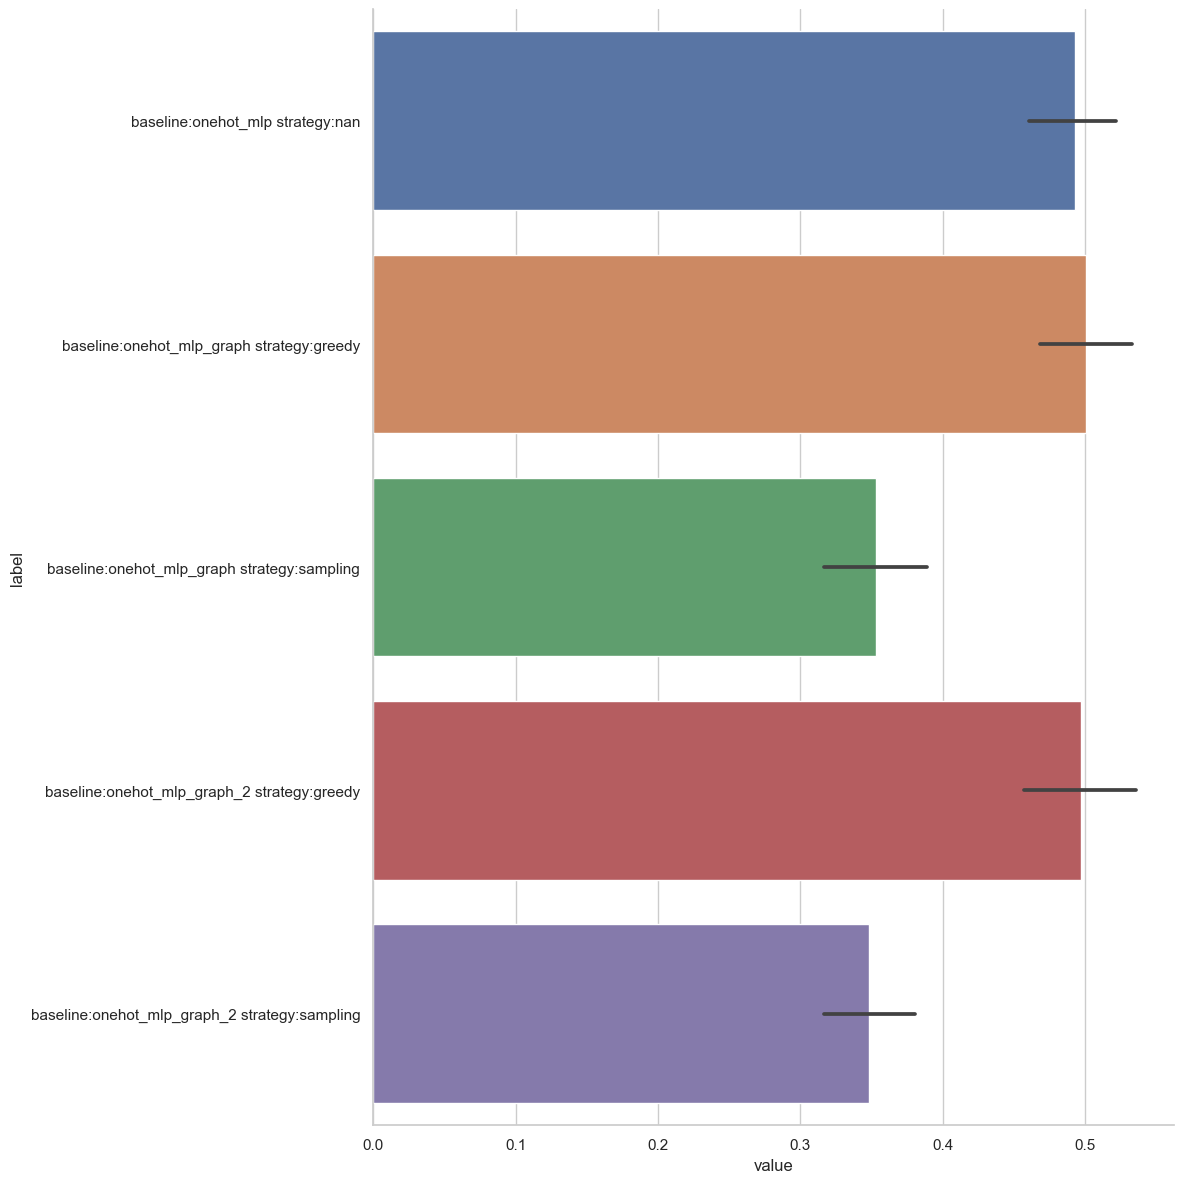

In [30]:
metric_name = 'accuracy'

w = (
    (metrics_df['name'] == metric_name) &
    (metrics_df['set'] == 'test') & 
    # (metrics_df['layers'] == '3') & 
    # (metrics_df['hidden_size'] == '20') & 
    # (metrics_df['lr'] == '1.e-3') & 
    # (metrics_df['y_encoding'] != 'numeric') & 
    (metrics_df['epoch'] == 990)
)
df = metrics_df[w]
sns.set_style("whitegrid")
# df['y_ordinal'] = df['y_ordinal'].astype(str)
sns.catplot(data=df, x='value', y='label', orient='h', kind='bar', sharex=False, height=12)


### First conclusion

* Hugh variance in the performance
* Numeric encoding has clearly lower performance

## Confusion Matrix

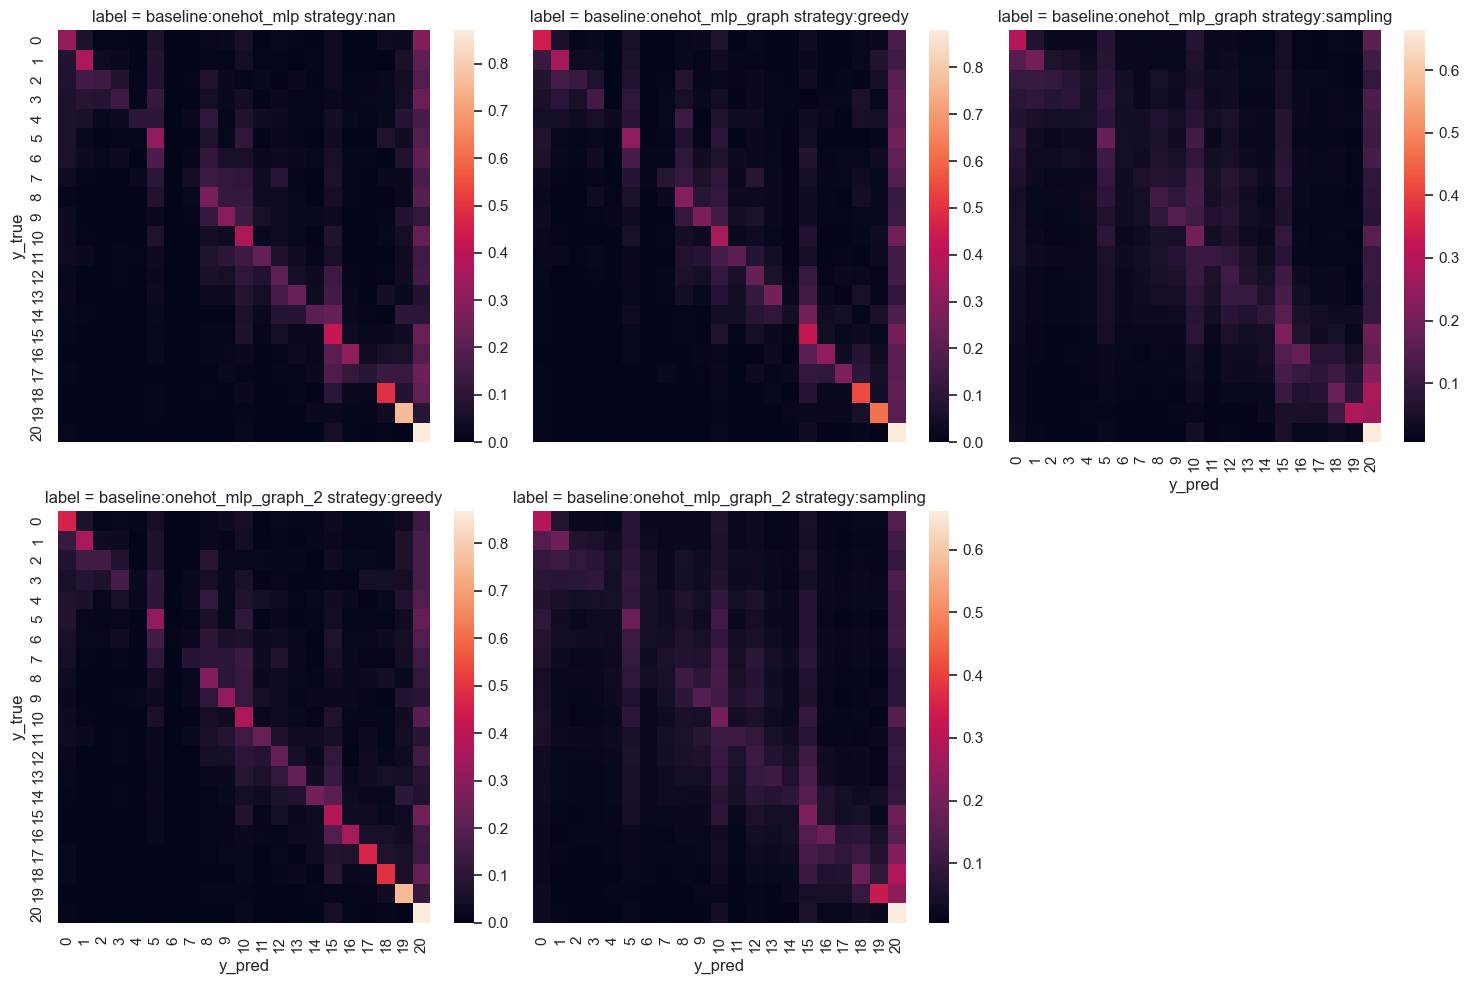

In [27]:
w = confusion_matrix_df['set'] == 'test'

df = confusion_matrix_df[w].copy()

def _plot_heatmap(data, x, y, values):
    dfg = data.groupby([x,y])[values].sum().reset_index()
    dfg[values] = dfg[values] / dfg.groupby([x])[values].transform('sum')
    cm = dfg.pivot_table(index=x, columns=y, values=values)
    sns.heatmap(cm)

plot_heatmap = lambda data, color: _plot_heatmap(
    data, x='y_true', y='y_pred', values='value')

fg = sns.FacetGrid(df, col='label', col_wrap=3, height=5)
fg.map_dataframe(plot_heatmap)

In the numeric encoding, the model is only taking actions that are a multiple of 5.

## Response surface

In [28]:
synthethetic_df.head()

,baseline,set,cv_split,epoch,prev_contribution,prev_punishment,contribution,proba,predicted,idx,round_number,prev_punishments,prev_contributions,pred_contribution,label
0,onehot_mlp,train,0,999,0.0,0.0,0,0.098716,False,NaN,NaN,NaN,NaN,NaN,baseline:onehot_mlp
1,onehot_mlp,train,0,999,0.0,0.0,1,0.039025,False,NaN,NaN,NaN,NaN,NaN,baseline:onehot_mlp
2,onehot_mlp,train,0,999,0.0,0.0,2,0.022405,False,NaN,NaN,NaN,NaN,NaN,baseline:onehot_mlp
3,onehot_mlp,train,0,999,0.0,0.0,3,0.022313,False,NaN,NaN,NaN,NaN,NaN,baseline:onehot_mlp
4,onehot_mlp,train,0,999,0.0,0.0,4,0.020893,False,NaN,NaN,NaN,NaN,NaN,baseline:onehot_mlp


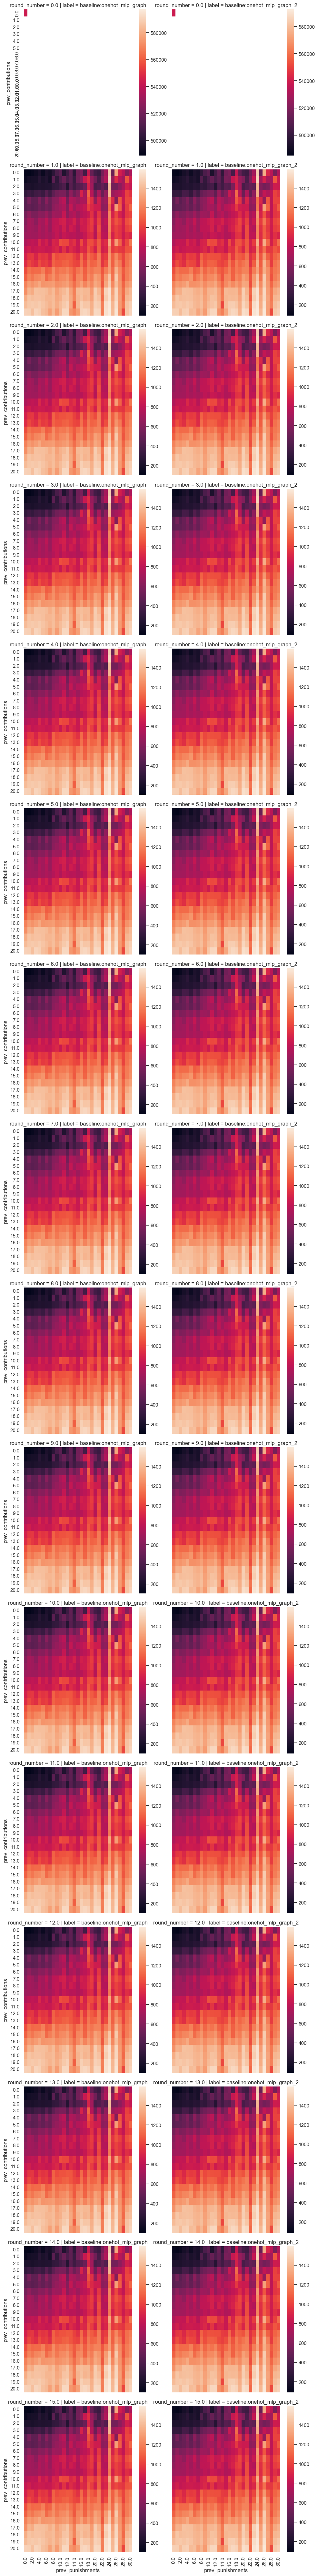

In [29]:
df = synthethetic_df.copy()

df = df[~df['prev_punishments'].isnull()]

df['exp_contribution'] = df['contribution'] * df['proba']

def _plot_heatmap(data, x, y, values):
    dfg = data.groupby([x,y])[values].sum()
    dfg = dfg.reset_index()
    cm = dfg.pivot_table(index=x, columns=y, values=values)
    sns.heatmap(cm)

plot_heatmap = lambda data, color: _plot_heatmap(
    data, x='prev_contributions', y='prev_punishments', values='exp_contribution')

fg = sns.FacetGrid(df, col='label', row='round_number', height=5)
fg.map_dataframe(plot_heatmap)